In [1]:
from utilities import init_bigquery_client
from google.cloud import bigquery
import os
import pandas as pd
import numpy as np
import plotly.express as px

#init BigQuery client
bq = init_bigquery_client()

Using BigQuery credentials: etl-testing-478716-c0b6c2c512e0.json


## Bulk Query

In [2]:
# Read from the 'user' table in BigQuery
query = """
    SELECT *
    FROM `etl-testing-478716.firebase_etl_prod.users`
"""
users_df = bq.query(query).to_dataframe()

# Read from the 'friends' table in BigQuery
query = """
    SELECT *
    FROM `etl-testing-478716.firebase_etl_prod.friends`
"""
friends_df = bq.query(query).to_dataframe()


/opt/miniconda3/envs/heyyall/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


## Friend Graph

In [3]:
#creating dataframe with parent_id and friend_id info merged
merged_df = friends_df.merge(users_df, left_on='parent_id', right_on='user_id', how='left', suffixes=('_friend', '_user'))
merged_df = merged_df.rename(columns={'fullName': 'fullName_parent', 'username': 'username_parent'})

#merge to get friend info
merged_df = merged_df.merge(users_df, left_on='friend_id', right_on='user_id', how='left', suffixes=('', '_user2'))

merged_df = merged_df.rename(columns={'fullName': 'fullName_friend', 'username': 'username_friend',
                                       'businessUser': 'businessUser_parent', 'businessUser_user2': 'businessUser_friend',
                                       'contactAccessGranted': 'contactAccessGranted_parent', 'contactAccessGranted_user2': 'contactAccessGranted_friend'})

#cleaning columns
columns_to_keep = ['parent_id', 'friend_id', 'fullName_parent', 'username_parent', 'businessUser_parent',
                   'contactAccessGranted_parent', 'fullName_friend', 'username_friend', 'businessUser_friend',
                   'contactAccessGranted_friend']
merged_df = merged_df.drop(columns=[x for x in merged_df.columns if x not in columns_to_keep])
#dropping rows with missing names (user may have deleted account)
merged_df = merged_df.dropna(subset=['fullName_parent', 'fullName_friend'])

In [4]:
merged_df.head()

,parent_id,friend_id,fullName_parent,username_parent,contactAccessGranted_parent,businessUser_parent,fullName_friend,username_friend,contactAccessGranted_friend,businessUser_friend
0,0PNBuWC4P5by27fmCRYtT89Jdtl1,j9TDokuozyVw4cQIibWntIKL7iA3,trask dix,traskyall,False,False,Goodjuan,goodjuan,True,False
1,3dedM4sg6xZVoCDDkM5WWgDGhLd2,j9TDokuozyVw4cQIibWntIKL7iA3,Brandon Quick,brandonquick,True,False,Goodjuan,goodjuan,True,False
2,3dedM4sg6xZVoCDDkM5WWgDGhLd2,j9TDokuozyVw4cQIibWntIKL7iA3,Brandon Quick,brandonquick,True,False,Goodjuan,goodjuan,True,False
3,9gHK6nfBJrVyx1543vFgvOKL85N2,j9TDokuozyVw4cQIibWntIKL7iA3,Dane Iliff,dane,True,False,Goodjuan,goodjuan,True,False
4,HMNMQxE4ZlOqFietyb4bnTSHZEv2,C8m3vjY3F6cwmhVhwpnuhqYY0Je2,Danny Kopack,dannykopack,True,False,Michelle Prichard,michelleprichard,True,False


In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp

In [6]:
G = nx.from_pandas_edgelist(merged_df, 'parent_id', 'friend_id')

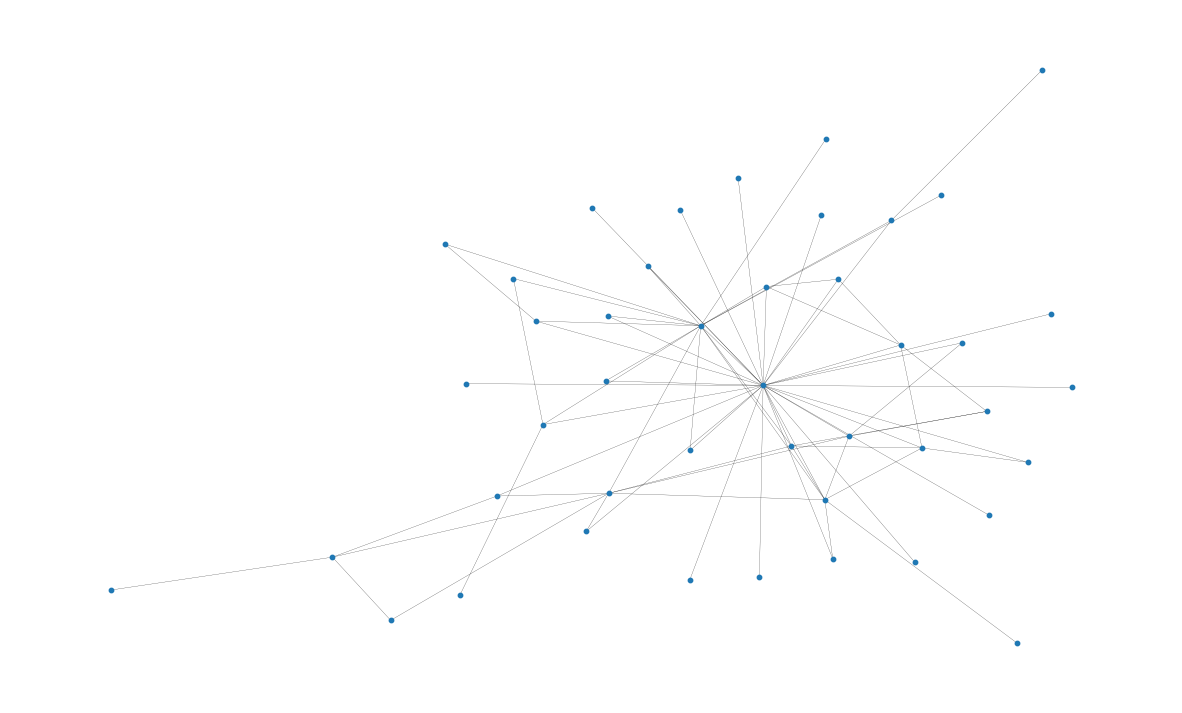

In [7]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

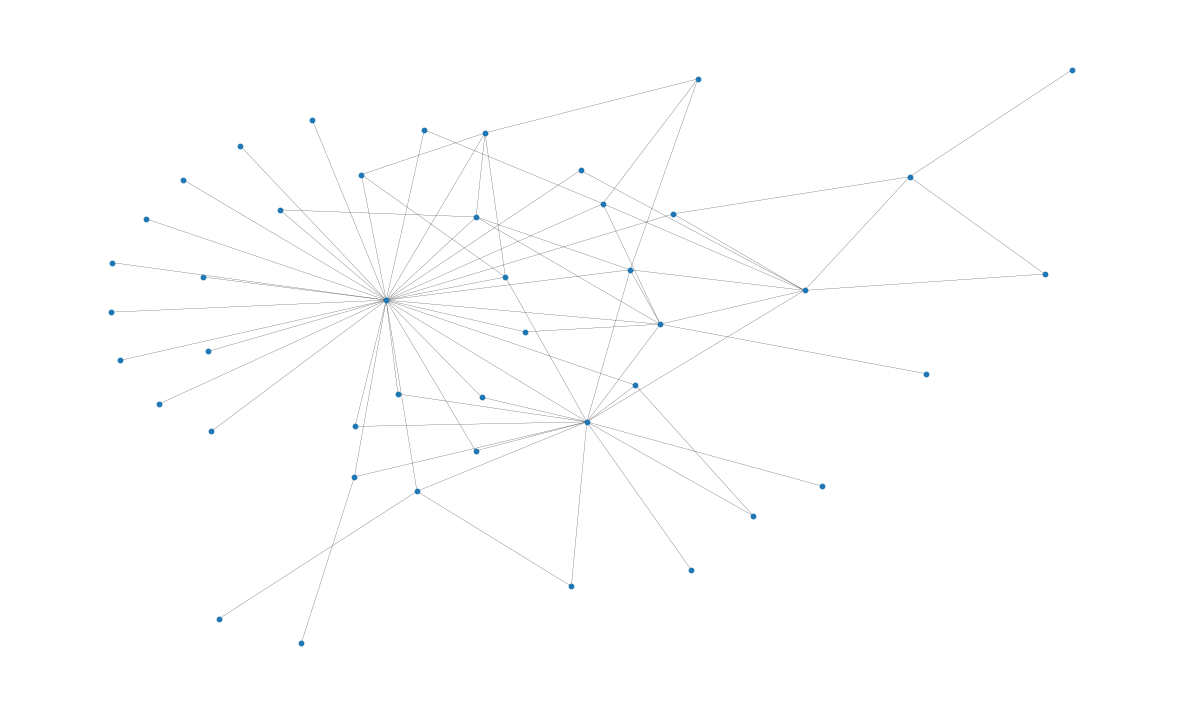

In [8]:
pos = nx.kamada_kawai_layout(G)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

### Network Overview 

In [39]:
#Average degree per node
np.mean([d for _, d in G.degree()])

np.float64(3.409090909090909)

In [41]:
#histogram of degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = pd.Series(degree_sequence).value_counts().sort_index()
fig = px.histogram(degree_count, x=degree_count.index, y=degree_count.values,
             labels={'x': 'Degree', 'y': 'Count'}, nbins=30,
             title='Degree Distribution of Friend Network')
fig.show()

In [42]:
#Shortest path lengths
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

Diameter of network graph is the longest of the shortest paths between points in the connected graph. If the graph is not connected diameter is infinite. 

Larger diameter indicates a more spread-out or less efficient network

In [44]:
#diameter of the graph
diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())
diameter

5

In [45]:
# Compute the average shortest path length for each node
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# The average over all nodes
np.mean(average_path_lengths)

np.float64(2.2758264462809916)

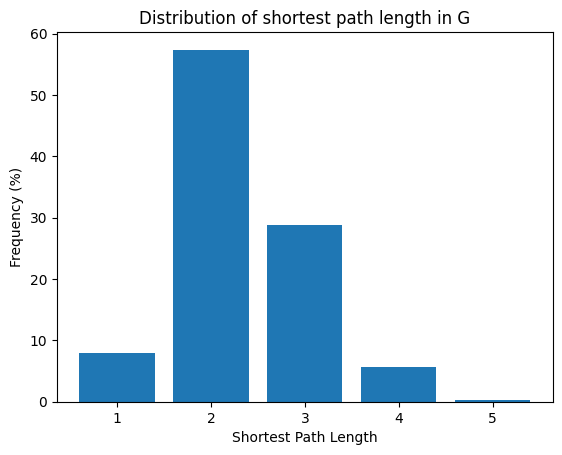

In [48]:
#Histogram of shortest path lengths
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots()
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    "Distribution of shortest path length in G", loc="center"
)
ax.set_xlabel("Shortest Path Length")
ax.set_ylabel("Frequency (%)")
plt.show()

In [49]:
#Graph density 
nx.density(G)

0.07928118393234672

In [50]:
#Number of components (Is everyone connected?)
nx.number_connected_components(G)

1

### Individual Importance

#### Degree Centrality

Degree centrality gives a ratio of degree/total network. Can be used to identify what users are the most connected in the network.

In [51]:
degree_centrality = nx.centrality.degree_centrality(
    G
)  # save results in a variable to use again

(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[('QFxHzayNZSRyDcrLAPJf5Oi9dY42', 0.7209302325581395),
 ('0PNBuWC4P5by27fmCRYtT89Jdtl1', 0.37209302325581395),
 ('3dedM4sg6xZVoCDDkM5WWgDGhLd2', 0.18604651162790697),
 ('HMNMQxE4ZlOqFietyb4bnTSHZEv2', 0.18604651162790697),
 ('j9TDokuozyVw4cQIibWntIKL7iA3', 0.13953488372093023),
 ('9gHK6nfBJrVyx1543vFgvOKL85N2', 0.11627906976744186),
 ('7D0Z9VCQW4ZCbe9hgcO5OCkqkx23', 0.11627906976744186),
 ('wmPmh04DuUdXlbBkPTXL60ymfPi1', 0.11627906976744186)]

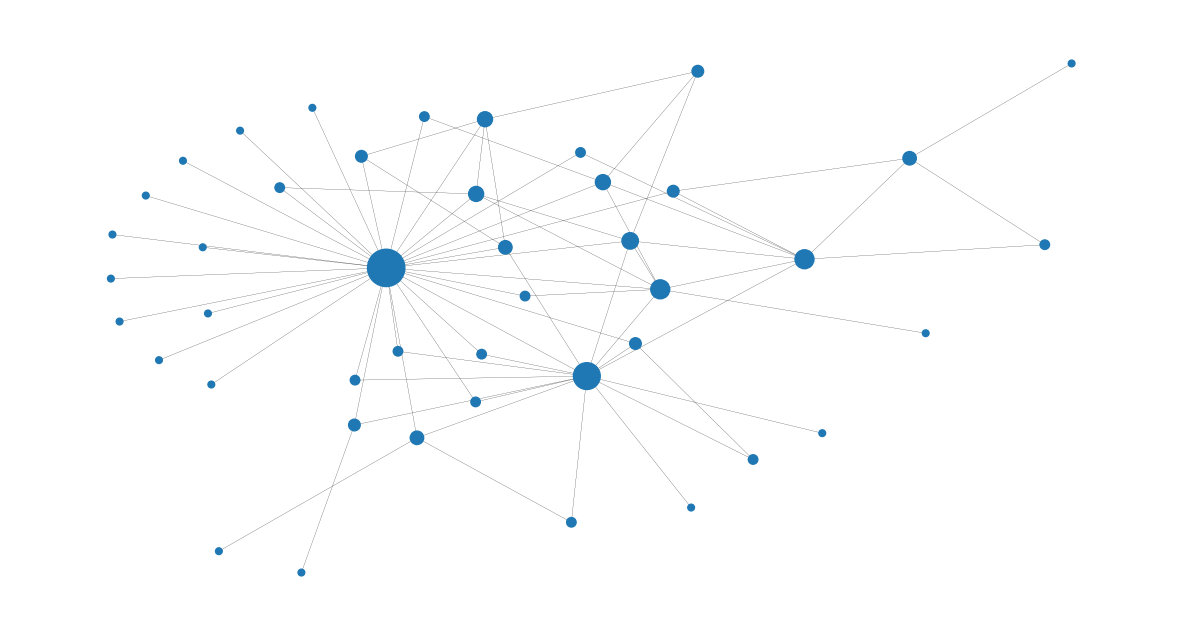

In [52]:
#Can replot with node size based on degree centrality
node_size = [
    v * 1000 for v in degree_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")
plt.show()

#### Closeness Centrality

Closeness centrality scores nodes by how quickly they can reach all other nodes, a high closeness means the node is closer to the center of the network? 

Who can reach everyone most quickly?

Closeness can be used to monitor for spread of information within the network. Can test if high closeness results in higher event attendance ?


In [53]:
closeness_centrality = nx.centrality.closeness_centrality(
    G
)  # save results in a variable to use again
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[('QFxHzayNZSRyDcrLAPJf5Oi9dY42', 0.7543859649122807),
 ('0PNBuWC4P5by27fmCRYtT89Jdtl1', 0.6056338028169014),
 ('3dedM4sg6xZVoCDDkM5WWgDGhLd2', 0.5308641975308642),
 ('j9TDokuozyVw4cQIibWntIKL7iA3', 0.5180722891566265),
 ('wmPmh04DuUdXlbBkPTXL60ymfPi1', 0.48863636363636365),
 ('LoRFoglnbvaGpHBwEHq9HTusQXl2', 0.48314606741573035),
 ('70kQa5U1jON7g39vnkFnHDmxSsR2', 0.48314606741573035),
 ('lEPaZX3MRNNo4p7EQRnLNP0jPDl2', 0.4777777777777778)]

#### Eigenvector Centrality

Eigenvector Centrality measures how connected a node is to other important nodes, where importance is based on a node's connectivity and the subsequent connectivity of it's connections. 

Who is connected to other well-connected people?
- In many analyses eigenvector centrality is treated as the identifier for most important nodes

In [54]:
eigenvector_centrality = nx.centrality.eigenvector_centrality(
    G
)  # save results in a variable to use again
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[('QFxHzayNZSRyDcrLAPJf5Oi9dY42', 0.5588230820659669),
 ('0PNBuWC4P5by27fmCRYtT89Jdtl1', 0.36119397446458895),
 ('3dedM4sg6xZVoCDDkM5WWgDGhLd2', 0.25746611695216703),
 ('j9TDokuozyVw4cQIibWntIKL7iA3', 0.22797120211432376),
 ('HMNMQxE4ZlOqFietyb4bnTSHZEv2', 0.18370643234387757),
 ('9gHK6nfBJrVyx1543vFgvOKL85N2', 0.1834199068079591),
 ('LoRFoglnbvaGpHBwEHq9HTusQXl2', 0.16875679596786286),
 ('wmPmh04DuUdXlbBkPTXL60ymfPi1', 0.16573697318114541),
 ('7D0Z9VCQW4ZCbe9hgcO5OCkqkx23', 0.15637698858401852),
 ('70kQa5U1jON7g39vnkFnHDmxSsR2', 0.142062799307997)]

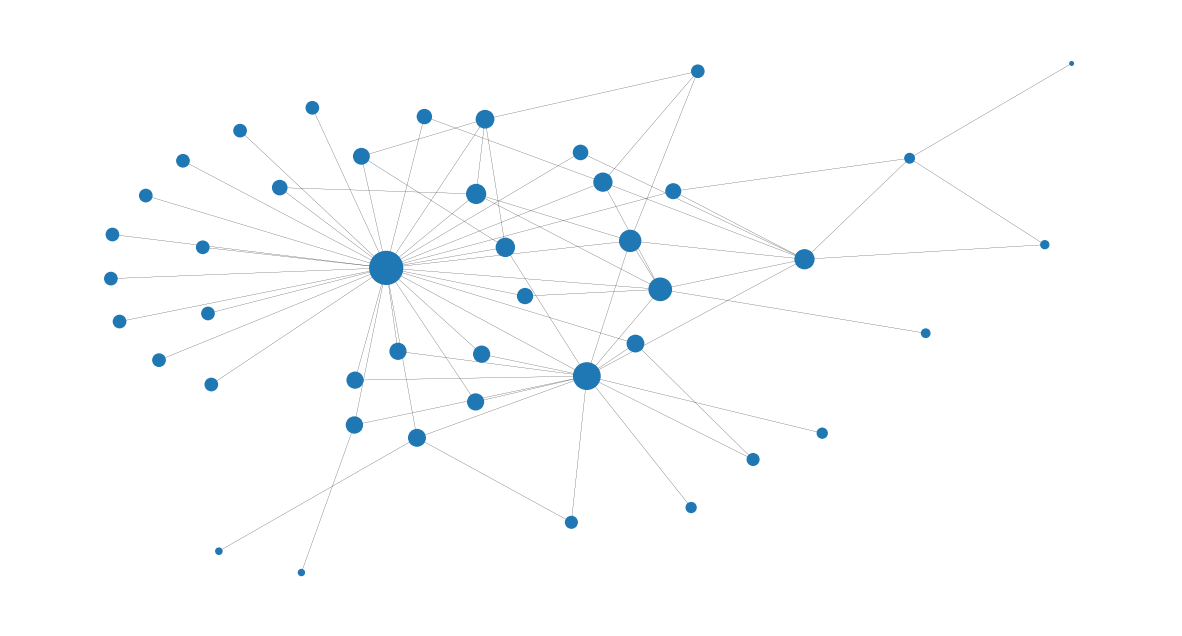

In [55]:
#Can replot with node size based on degree centrality
node_size = [
    v * 1000 for v in eigenvector_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")
plt.show()

#### Betweenness Centrality 

Betweenness centrality measures how often a node appears on the shortest path between other nodes which is then intepreted as a metric of bridging or brokering

In [13]:
betweenness_centrality = nx.betweenness_centrality(G, k=10, endpoints=True)

In [59]:
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[('QFxHzayNZSRyDcrLAPJf5Oi9dY42', 0.7141149870801033),
 ('0PNBuWC4P5by27fmCRYtT89Jdtl1', 0.2716592838685862),
 ('70kQa5U1jON7g39vnkFnHDmxSsR2', 0.16782945736434107),
 ('3dedM4sg6xZVoCDDkM5WWgDGhLd2', 0.15534791435954226),
 ('HMNMQxE4ZlOqFietyb4bnTSHZEv2', 0.15072443706164637),
 ('lEPaZX3MRNNo4p7EQRnLNP0jPDl2', 0.14186046511627906),
 ('LoRFoglnbvaGpHBwEHq9HTusQXl2', 0.12296511627906977),
 ('asnutFbIInUs2tmjBap7ENOS0L82', 0.12093023255813953),
 ('ObaPVf5KFsU4bWtCZY0fVf8NrE12', 0.12093023255813953),
 ('SmWV8Lo1MmbKyX0VkXzGs6VJG1t2', 0.12093023255813953)]

### Community Detection Algorithms

#community.greedy_modularity_communities

Clustering coefficient is the probability for a node v that two random friends of v are friends with each other. The average_clustering is the average of all node level clustering coefficients for the network graph.

In [61]:
avg_clustering_coeff = nx.average_clustering(G)

Triangles define a looped connection which can be seen as a closed friend group. They indicate triadic closure = the tendency for "friends of friends to become friends"

In [66]:
# Count triangles for each node
triangles = nx.triangles(G)

# Total triangles in network (each counted 3 times, once per node)
total_triangles = sum(triangles.values()) // 3

print(total_triangles)
print(f"Average triangles per node : {np.mean(list(triangles.values())):.4f}")
print(f"Median triangles per node: {np.median(list(triangles.values())):.4f}")

32
Average triangles per node : 2.1818
Median triangles per node: 1.0000


#### Aysnc Community Algorithms

Automatic Community Count - encompasses alogrithms that find the optimal number of communities based on the network structure (similar to hierarchical clustering)

Modularity = measures hwo strongly a network divides into distinct groups, with dense internal connections and sparse external connections between groups. Compares newtork groups to randomized groups to determine if there is non-random structure.

Louvain (Most Popular) - fast hierarchical algorithm that maximizes modularity 

In [9]:
import community as community_louvain
communities = community_louvain.best_partition(G)

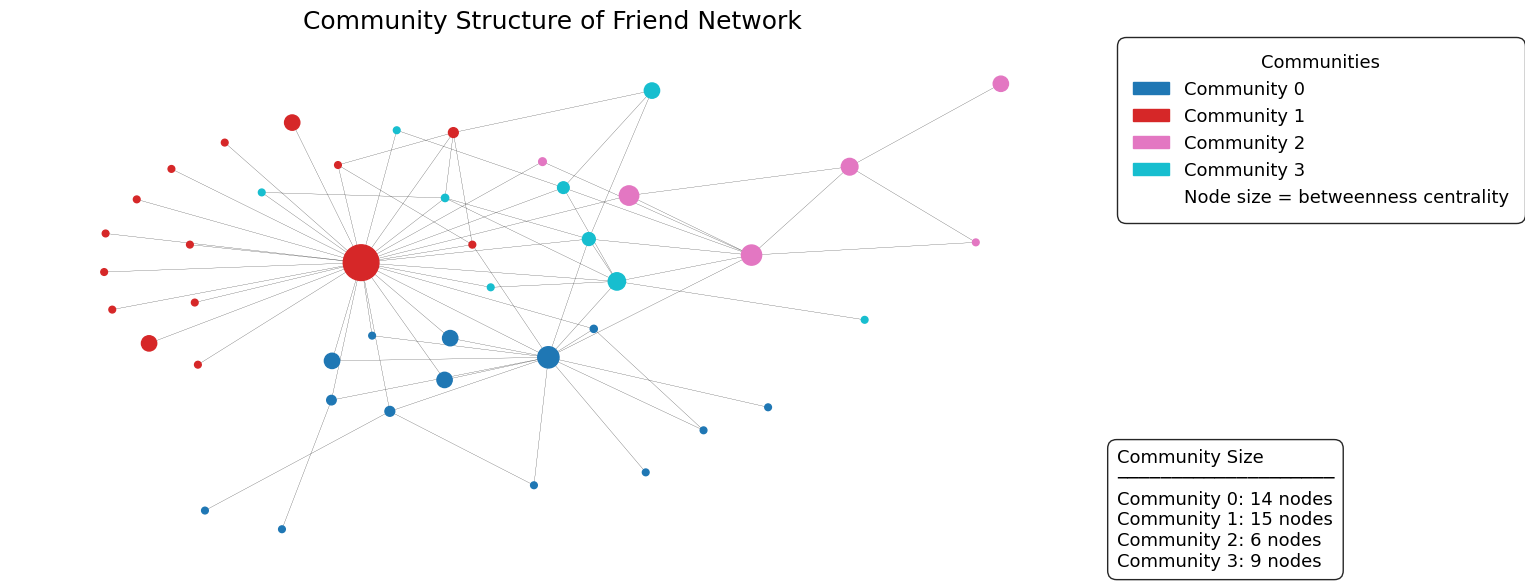

In [66]:
# Creating color map for communities
import matplotlib.patches as mpatches
unique_communities = sorted(set(communities.values()))
community_to_color = {comm: plt.cm.tab10(i / max(1, len(unique_communities)-1)) for i, comm in enumerate(unique_communities)}
colors = [community_to_color[communities[node]] for node in G.nodes()]

node_size = [
    v * 1000 for v in betweenness_centrality.values()
]  # set up nodes size for a nice graph representation
fig, ax = plt.subplots(figsize=(14, 7))
font_family = 'DejaVu Sans'
font_size = 13

nx.draw_networkx(G, pos=pos, node_color=colors, node_size=node_size, with_labels=False, width=0.15, cmap='tab10', ax=ax)

# Add legend with correct color mapping for community names
patches = [mpatches.Patch(color=community_to_color[comm], label=f'Community {comm}') for comm in unique_communities]
# Add a dummy patch for node size explanation
patches.append(mpatches.Patch(color='none', label='Node size = betweenness centrality'))
legend = ax.legend(handles=patches, loc='upper left', bbox_to_anchor=(1.02, 1.0), title='Communities',
                   fontsize=font_size, title_fontsize=font_size, frameon=True,
                   fancybox=True, shadow=False, edgecolor='black')
legend.get_frame().set_boxstyle('round,pad=0.5')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.85)
plt.setp(legend.get_texts(), fontfamily=font_family)
plt.setp(legend.get_title(), fontfamily=font_family)

# Add centered title
ax.set_title('Community Structure of Friend Network', fontsize=18, fontfamily=font_family, loc='center')

# How big are communities? Add annotation in the bottom right for each community
from collections import Counter
count_dict = Counter(communities.values())
sorted_dict = {key: value for key, value in sorted(count_dict.items(), key=lambda item: item[0], reverse=False)}

# Build the text string with title and all communities
annotation_text = "Community Size\n" + "─" * 20 + "\n"
for k, v in sorted_dict.items():
    annotation_text += f"Community {k}: {v} nodes\n"

# Remove trailing newline
annotation_text = annotation_text.rstrip('\n')

x = 1.02
y_start = 0.01
ax.annotate(annotation_text, xy=(x, y_start), xycoords='axes fraction', 
            fontsize=font_size, ha='left', va='bottom', fontfamily=font_family,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.85, ec='black'))

ax.axis("off")
plt.savefig('community_plot.png', bbox_inches='tight')

In [27]:
#How big are communities?
from collections import Counter
count_dict = Counter(communities.values())
for k, v in count_dict.items():
    print(f"Community {k}: {v} nodes")

Community 0: 14 nodes
Community 3: 9 nodes
Community 2: 6 nodes
Community 1: 15 nodes


In [41]:
# Sort by key using dictionary comprehension
sorted_dict = {key: value for key, value in sorted(count_dict.items(), key=lambda item: item[0], reverse=True)}

In [42]:
sorted_dict

{3: 9, 2: 6, 1: 15, 0: 14}